In [4]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

^C
  Using cached labelme-5.5.0.tar.gz (1.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached tensorflow-2.17.0-cp312-cp312-win_amd64.whl.metadata (3.2 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached albumentations-1.4.17-py3-none-any.whl.metadata (38 kB)
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached imgviz-1.7.5.tar.gz (7.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'don

ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python312\\Scripts\\wheel.exe' -> 'C:\\Python312\\Scripts\\wheel.exe.deleteme'


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import os 
import time
import uuid
import cv2

In [10]:
IMAGES_PATH = os.path.join('data','images')
number_images = 15

In [11]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [12]:
!labelme

2024-10-08 00:00:31,205 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\razae\.labelmerc


In [13]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [14]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [31]:
tf.config.list_physical_devices('GPU')

[]

In [32]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [33]:
images.as_numpy_iterator().next()

b'data\\images\\ebef38eb-8499-11ef-84fe-16058fd7d919.jpg'

In [18]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [35]:
images = images.map(load_image)

In [36]:
images.as_numpy_iterator().next()

array([[[103,  98,  78],
        [101,  94,  75],
        [ 91,  78,  59],
        ...,
        [ 33,  29,  30],
        [ 29,  24,  28],
        [ 43,  38,  42]],

       [[ 97,  90,  64],
        [103,  93,  68],
        [101,  86,  63],
        ...,
        [ 31,  27,  26],
        [ 29,  25,  26],
        [ 40,  36,  37]],

       [[ 97,  85,  47],
        [104,  90,  55],
        [105,  89,  56],
        ...,
        [ 31,  26,  22],
        [ 31,  27,  24],
        [ 35,  34,  32]],

       ...,

       [[104, 101,  96],
        [104, 101,  94],
        [105, 105,  93],
        ...,
        [126, 116, 115],
        [124, 119, 116],
        [124, 120, 117]],

       [[107, 103, 102],
        [104, 100,  97],
        [103, 103,  95],
        ...,
        [126, 118, 115],
        [123, 120, 115],
        [122, 121, 116]],

       [[108, 104, 105],
        [103,  99,  98],
        [101, 100,  95],
        ...,
        [123, 118, 114],
        [122, 119, 114],
        [120, 119, 114]]

In [37]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [38]:
image_generator = images.batch(4).as_numpy_iterator()

In [39]:
plot_images = image_generator.next()

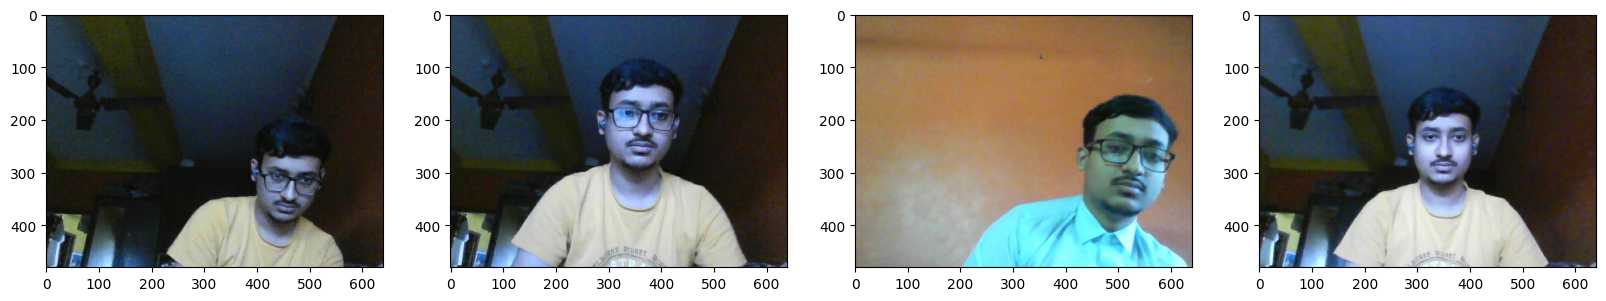

In [40]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [42]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)   

In [43]:
import albumentations as alb

In [44]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [56]:
img = cv2.imread(os.path.join('data','train', 'images','0b4c60b0-8499-11ef-8d4a-16058fd7d919.jpg'))

In [57]:
with open(os.path.join('data', 'train', 'labels', '0b4c60b0-8499-11ef-8d4a-16058fd7d919.json'), 'r') as f:
    label = json.load(f)

In [58]:
label['shapes'][0]['points']

[[410.27777777777777, 166.66666666666669],
 [544.7222222222222, 331.11111111111114]]

In [59]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [16]:
coords

NameError: name 'coords' is not defined

In [61]:
coords = list(np.divide(coords, [640,480,640,480]))

In [62]:
coords

[0.6410590277777778,
 0.34722222222222227,
 0.8511284722222221,
 0.6898148148148149]

In [63]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [64]:
augmented['bboxes'][0][2:]

(1.0, 0.6913580246913581)

In [65]:
augmented['bboxes']

[(0.7295061728395061, 0.32592592592592595, 1.0, 0.6913580246913581)]

In [66]:
augmented['image']

array([[[111, 152, 145],
        [113, 151, 145],
        [114, 150, 144],
        ...,
        [110,  94,  88],
        [115,  95,  90],
        [119,  97,  92]],

       [[110, 147, 143],
        [112, 148, 142],
        [116, 150, 144],
        ...,
        [108,  92,  86],
        [113,  94,  89],
        [116,  96,  91]],

       [[113, 150, 146],
        [114, 149, 145],
        [116, 150, 144],
        ...,
        [105,  91,  85],
        [111,  95,  88],
        [112,  96,  89]],

       ...,

       [[170, 158, 134],
        [174, 155, 134],
        [181, 157, 137],
        ...,
        [128, 155, 159],
        [130, 154, 160],
        [129, 153, 159]],

       [[179, 165, 143],
        [198, 176, 158],
        [203, 177, 160],
        ...,
        [134, 159, 163],
        [135, 157, 163],
        [134, 156, 162]],

       [[177, 160, 141],
        [181, 159, 141],
        [186, 162, 144],
        ...,
        [133, 155, 161],
        [132, 154, 160],
        [134, 156, 162]]

In [15]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

NameError: name 'augmented' is not defined

In [68]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.2660590277777778, 0.2106481481481481, 0.0021701388888888838, 0.724537037037037, 'face'].
x_max is less than or equal to x_min for bbox [0.13151041666666666, 0.49189814814814814, 0.0, 0.9101963409192325, 'face'].
x_max is less than or equal to x_min for bbox [0.2808159722222222, 0.3807870370370371, -4.4408920985006264e-17, 0.8460442691211922, 'face'].
x_max is less than or equal to x_min for bbox [0.19574652777777776, 0.28935185185185186, 0.0004340277777777679, 0.6782407407407407, 'face'].
x_max is less than or equal to x_min for bbox [0.12543402777777776, 0.2685185185185185, 0.0, 0.7054043839758125, 'face'].
x_max is less than or equal to x_min for bbox [0.2808159722222222, 0.40162037037037035, -4.4408920985006264e-17, 0.885573866777225, 'face'].
x_max is less than or equal to x_min for bbox [0.09071180555555554, 0.59375, 0.0, 0.9588792802236198, 'face'].
x_max is less than or equal to x_min for bbox [0.07074652777777776, 0.6053240740740

In [19]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [20]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [21]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [22]:
train_images.as_numpy_iterator().next()

array([[[0.44699755, 0.50490195, 0.6215686 ],
        [0.4490196 , 0.50784314, 0.63039213],
        [0.45998776, 0.5188113 , 0.6403799 ],
        ...,
        [0.8759804 , 1.        , 0.98970586],
        [0.88186276, 0.99969363, 0.9918505 ],
        [0.8872549 , 1.        , 0.99460787]],

       [[0.46078432, 0.5156863 , 0.62107843],
        [0.46023285, 0.5268995 , 0.63572305],
        [0.4670343 , 0.5338848 , 0.6426471 ],
        ...,
        [0.8666667 , 1.        , 0.9882353 ],
        [0.875674  , 1.        , 0.99123776],
        [0.88057595, 1.        , 0.9970588 ]],

       [[0.45539215, 0.525     , 0.6091912 ],
        [0.4588848 , 0.5420956 , 0.61629903],
        [0.45882353, 0.545527  , 0.627451  ],
        ...,
        [0.8661765 , 1.        , 0.9877451 ],
        [0.87352943, 1.        , 0.9882353 ],
        [0.8791054 , 0.99969363, 0.9903799 ]],

       ...,

       [[0.76145834, 0.7472426 , 0.69822305],
        [0.7420956 , 0.7307598 , 0.6572304 ],
        [0.71954656, 0

In [23]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [24]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [25]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [26]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [27]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1774, 0.374 , 0.4368, 0.6826], dtype=float16))

In [28]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(10140, 10140, 2220, 2220, 2100, 2100)

In [29]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [30]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [31]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [32]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.09644, 0.328  , 0.368  , 0.653  ],
        [0.3894 , 0.1257 , 0.613  , 0.3577 ],
        [0.4426 , 0.4424 , 0.8315 , 0.9697 ],
        [0.     , 0.3176 , 0.195  , 0.683  ],
        [0.297  , 0.493  , 0.5366 , 0.826  ],
        [0.4883 , 0.1649 , 0.792  , 0.5327 ],
        [0.364  , 0.161  , 0.6543 , 0.5645 ],
        [0.1812 , 0.1748 , 0.4639 , 0.4883 ]], dtype=float16))

In [33]:
data_samples = train.as_numpy_iterator()

In [34]:
res = data_samples.next()

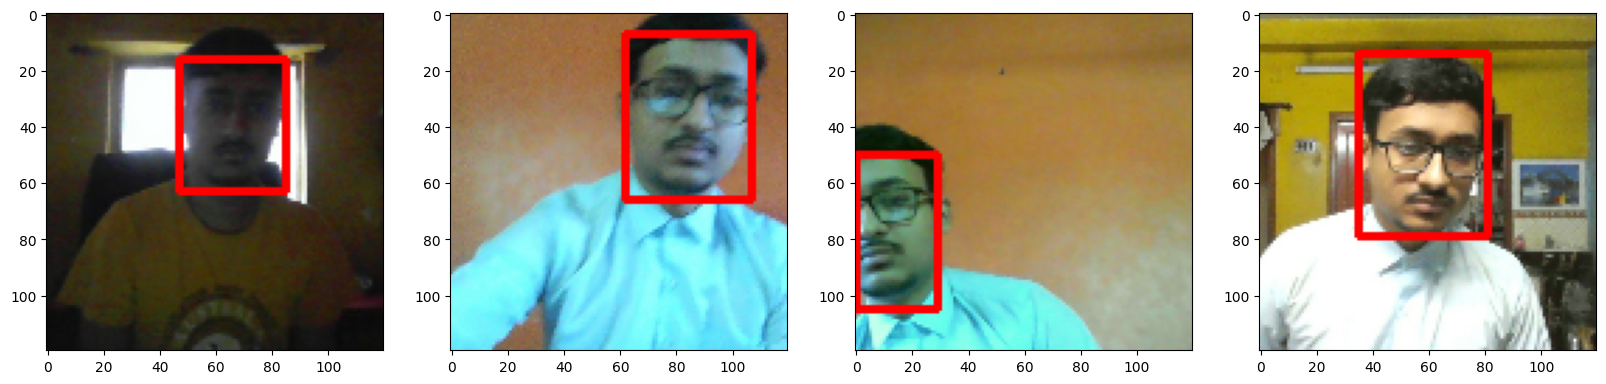

In [35]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = (res[0][idx]*255).astype(np.uint8)
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [37]:
vgg = VGG16(include_top=False)

In [38]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [39]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [40]:
facetracker = build_model()

In [41]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_5[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d_2 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

In [42]:
X, y = train.as_numpy_iterator().next()

In [43]:
X.shape

(8, 120, 120, 3)

In [44]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [45]:
classes, coords

(array([[0.5794058 ],
        [0.508035  ],
        [0.5042345 ],
        [0.55905426],
        [0.49482507],
        [0.520786  ],
        [0.49723676],
        [0.50124425]], dtype=float32),
 array([[0.5886427 , 0.54111296, 0.5531256 , 0.43217218],
        [0.5374944 , 0.52424383, 0.47163558, 0.41486332],
        [0.5738877 , 0.544183  , 0.4934421 , 0.3510317 ],
        [0.6295216 , 0.6191814 , 0.5303814 , 0.43324715],
        [0.43711638, 0.46293926, 0.5191872 , 0.3461105 ],
        [0.66368437, 0.545599  , 0.5073017 , 0.44450825],
        [0.55891263, 0.56058085, 0.47463384, 0.4513392 ],
        [0.4884665 , 0.6146121 , 0.4928445 , 0.4253589 ]], dtype=float32))

In [46]:
initial_learning_rate = 0.0001
batches_per_epoch = len(train)
lr_decay = (1.0 / 0.75 - 1.0) / batches_per_epoch

In [47]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=batches_per_epoch,
    decay_rate=lr_decay*1000,
    staircase=False  # Set to True for discrete decay at integer multiples of decay_steps
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [48]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [49]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [50]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.5673227>

In [51]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6839776>

In [52]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.5673227>

In [53]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [54]:
model = FaceTracker(facetracker)

In [55]:
model.compile(opt, classloss, regressloss)

In [56]:
logdir='logs'

In [57]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [58]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
1268/1268 [==============================] - 1500s 1s/step - total_loss: 0.1690 - class_loss: 0.0486 - regress_loss: 0.1447 - val_total_loss: 0.0230 - val_class_loss: 3.0061e-04 - val_regress_loss: 0.0229
Epoch 2/10
1268/1268 [==============================] - 1994s 2s/step - total_loss: 0.0304 - class_loss: 0.0097 - regress_loss: 0.0256 - val_total_loss: 0.0153 - val_class_loss: 9.5866e-05 - val_regress_loss: 0.0152
Epoch 3/10
1268/1268 [==============================] - 2503s 2s/step - total_loss: 0.0155 - class_loss: 0.0039 - regress_loss: 0.0135 - val_total_loss: 0.0108 - val_class_loss: 8.2473e-05 - val_regress_loss: 0.0107
Epoch 4/10
1268/1268 [==============================] - 2584s 2s/step - total_loss: 0.0111 - class_loss: 0.0022 - regress_loss: 0.0100 - val_total_loss: 0.0072 - val_class_loss: 3.0027e-05 - val_regress_loss: 0.0072
Epoch 5/10
1268/1268 [==============================] - 1424s 1s/step - total_loss: 0.0096 - class_loss: 0.0018 - regress_loss: 0.0088 -

In [59]:
hist.history

{'total_loss': [0.01660698652267456,
  0.026563581079244614,
  0.002574420068413019,
  0.004685352556407452,
  0.0013227005256339908,
  0.003039267612621188,
  0.005665972363203764,
  0.001960263354703784,
  0.003441218053922057,
  0.0038257145788520575],
 'class_loss': [0.00044640793930739164,
  0.012982257641851902,
  2.9206346425780794e-06,
  0.0005049966857768595,
  0.00023763692297507077,
  0.0002900920808315277,
  2.3394877644022927e-06,
  1.022230844682781e-05,
  5.641837196890265e-05,
  4.674801675719209e-05],
 'regress_loss': [0.016383782029151917,
  0.02007245272397995,
  0.002572959754616022,
  0.004432854242622852,
  0.0012038820423185825,
  0.0028942215722054243,
  0.005664802622050047,
  0.0019551522564142942,
  0.0034130087587982416,
  0.003802340477705002],
 'val_total_loss': [0.023012446239590645,
  0.015271658077836037,
  0.0107759153470397,
  0.007246730849146843,
  0.0059387036599218845,
  0.011133609339594841,
  0.011798970401287079,
  0.011436140164732933,
  0.004

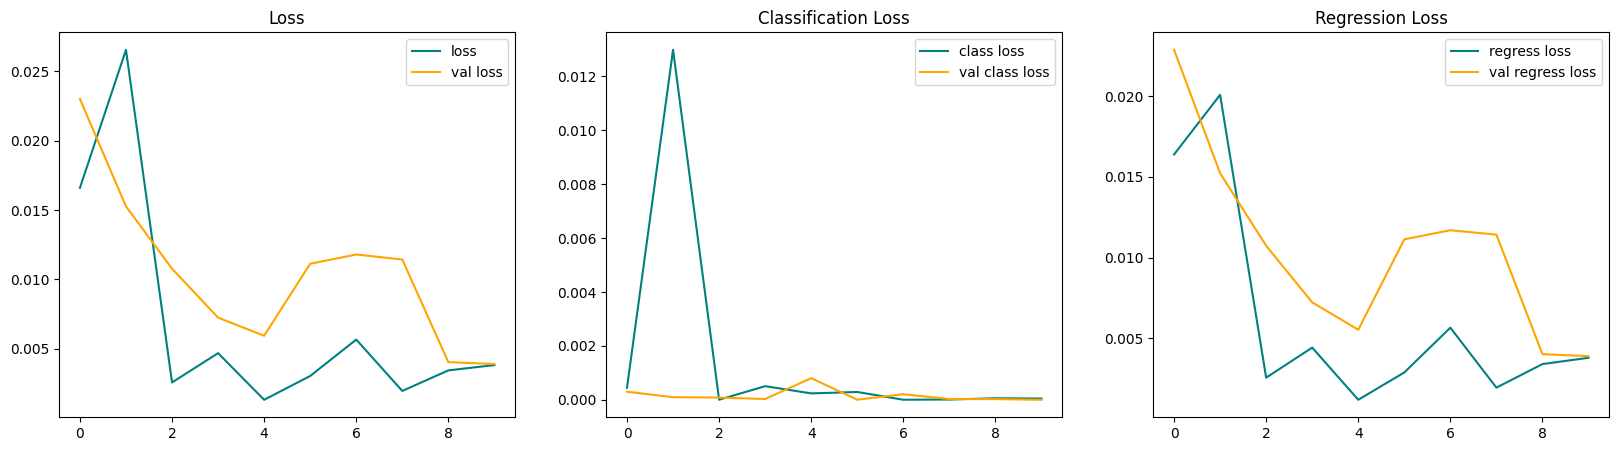

In [60]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [61]:
test_data = test.as_numpy_iterator()

In [62]:
test_sample = test_data.next()

In [63]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 373ms/step


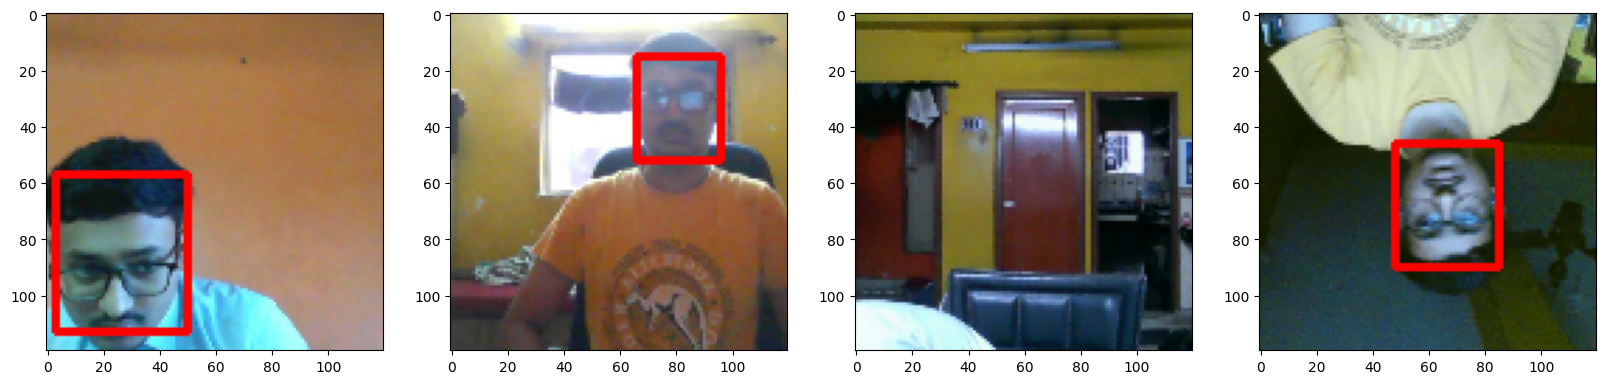

In [64]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = (test_sample[0][idx]*255).astype(np.uint8)
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [65]:
from tensorflow.keras.models import load_model

In [67]:
facetracker.save('facetracker.h5')

In [68]:
facetracker = load_model('facetracker.h5')

In [70]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 118ms/step


KeyboardInterrupt: 